## Stocks Trading Strategy Based on Daily Price Change - Multiple Stocks
This strategy is to :
1. Buy one share of certain stocks in a predefined portfolio if the stocks price falls more than a certain percentage (pct change of closing price)
2. Hold all the shares till today
3. Evaluate the gain or loss.

## Disclaimer : 
This is again a dumbass strategy and I'm not recommending anyone to follow it, this whole notebook is just a toy.

### 1. First thing first, import necessary libraries, some may not be used though...

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance
import quandl 
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

### 2. Get the stocks price data and work with it

In [2]:
def get_data(tickers, startdate, enddate):
    data = pdr.DataReader(tickers, 'yahoo', start=startdate, end=enddate)
    return data

tickers = ['ASML', 'NVDA', 'BLK', 'AAPL', 'JPM'] # pick your own stocks
all_data = get_data(tickers, datetime.datetime(2020,1,2), datetime.date.today()).stack().reset_index() # choose your trading time frame

In [3]:
all_data.head()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02,ASML,299.266418,302.829987,303.320007,300.609985,301.269989,573600.0
1,2020-01-02,NVDA,59.844322,59.977501,59.977501,59.180000,59.687500,23753600.0
2,2020-01-02,BLK,491.065094,508.980011,510.000000,504.920013,510.000000,560400.0
3,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0
4,2020-01-02,JPM,133.611008,141.089996,141.100006,139.259995,139.789993,10803700.0


In [4]:
all_data.tail()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume
2075,2021-08-25,ASML,807.869995,807.869995,813.369995,805.000000,808.419983,471100.0
2076,2021-08-25,NVDA,222.130005,222.130005,224.699997,217.220001,217.369995,34709000.0
2077,2021-08-25,BLK,939.520020,939.520020,945.859985,930.289978,933.549988,329900.0
2078,2021-08-25,AAPL,148.360001,148.360001,150.320007,147.800003,149.809998,58924000.0
2079,2021-08-25,JPM,160.919998,160.919998,161.779999,157.800003,158.509995,11329900.0


In [5]:
all_data['Ytd Close'] = all_data.Close.shift(len(tickers)) # shift by how many tickers we are analyzing
all_data['Diff'] = all_data.Close - all_data['Ytd Close']
all_data['Closing Price Pct Change'] = all_data.Close.pct_change(len(tickers)) # daily price percentage change
# data = data.iloc[1:, :] # remove the first row
all_data.head()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,Ytd Close,Diff,Closing Price Pct Change
0,2020-01-02,ASML,299.266418,302.829987,303.320007,300.609985,301.269989,573600.0,NaN,NaN,NaN
1,2020-01-02,NVDA,59.844322,59.977501,59.977501,59.180000,59.687500,23753600.0,NaN,NaN,NaN
2,2020-01-02,BLK,491.065094,508.980011,510.000000,504.920013,510.000000,560400.0,NaN,NaN,NaN
3,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0,NaN,NaN,NaN
4,2020-01-02,JPM,133.611008,141.089996,141.100006,139.259995,139.789993,10803700.0,NaN,NaN,NaN


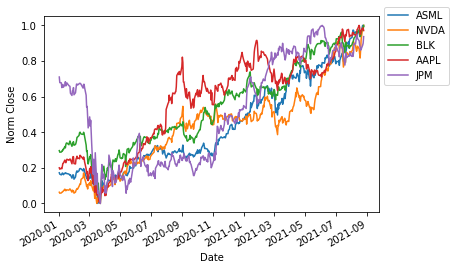

In [6]:
# create a normalized closing price column so we can prepare different stocks
grouper = all_data.groupby('Symbols')['Close']
maxes = grouper.transform('max')
mins = grouper.transform('min')
all_data['Norm Close'] = (all_data.Close - mins)/(maxes - mins)

# plot the closing price
closeplot = sns.lineplot(data=all_data, x='Date', y='Norm Close', hue='Symbols')
closeplot.get_figure().autofmt_xdate()
closeplot.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1);

,count,mean,std,min,25%,50%,75%,max
Symbols,,,,,,,,
AAPL,415.0,0.001957,0.025104,-0.128647,-0.009183,0.001255,0.014627,0.119808
ASML,415.0,0.002770,0.028277,-0.173492,-0.010721,0.001788,0.018941,0.116063
BLK,415.0,0.001796,0.025216,-0.136546,-0.008093,0.002676,0.012701,0.135239
JPM,415.0,0.000710,0.028114,-0.149649,-0.011915,0.000060,0.012806,0.180125
NVDA,415.0,0.003700,0.032838,-0.184521,-0.011924,0.003396,0.023280,0.171564


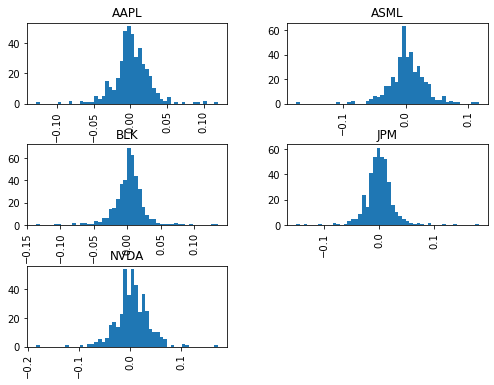

In [7]:
# Plot the distribution of 'Percentage Price Change'
all_data['Closing Price Pct Change'].hist(by=all_data['Symbols'], bins=50, figsize=(8,6))

# Pull up summary statistics table
all_data.groupby('Symbols')['Closing Price Pct Change'].describe()

### 3. Let's create some helper functions before implementing the trading strategy

In [8]:
def pct_change(buy, sell):
    return (sell - buy) / buy

In [9]:
def mean(value, n):
    return value / n

### 4. The signal function

In [10]:
# produce a signal when to buy or sell the stocks
def signal(pct_change):
    if pct_change < -0.05: # choose your benchmark fall percentage
        return 'Buy'

### 5. Implement the strategy

In [11]:
mydate = []
mysymbols = []
mypctchange = []
myshares = []
mytotalshares = []
mybuyingprice = []
mytotalcost = []

for i, row in all_data.iterrows():
    if signal(row['Closing Price Pct Change']) == 'Buy':
        mydate.append(row.Date)
        mysymbols.append(row.Symbols)
        mypctchange.append(row['Closing Price Pct Change'])
        myshares.append(1)
        mytotalshares.append(sum(myshares))
        mybuyingprice.append(row['Open'])
        mytotalcost.append(sum(mybuyingprice))

# create my shares purchasing df
mydf = pd.DataFrame({'Date': mydate,
                     'Symbols': mysymbols,
                     'Closing Price Pct Change': mypctchange,
                     'Daily Shares Bought': myshares,
                     'Total Shares': mytotalshares,
                     'Buying Price': mybuyingprice,
                     'Total Cost': mytotalcost})

#### 6. Results

In [12]:
# overall performance evaluation
myavgcost = mean(mytotalcost[-1], sum(myshares))

grpclose = all_data.groupby('Symbols')['Close']
weightedclose = grpclose.tail(1).sum() / len(tickers)
gainloss = pct_change(myavgcost, weightedclose)

print('Total shares bought: ', sum(myshares))
print('Average cost: ', myavgcost)
print('Total cost:', mytotalcost[-1] * 8) # convert to your own currency, mop in this case, which is to simply multiply by 8
print('Gain/Loss pct: {}%'.format(round(gainloss*100, 2)))

Total shares bought:  61
Average cost:  205.28151621584033
Total cost: 100177.37991333008
Gain/Loss pct: 122.02%


In [13]:
mydf.head()

,Date,Symbols,Closing Price Pct Change,Daily Shares Bought,Total Shares,Buying Price,Total Cost
0,2020-02-24,ASML,-0.050980,1,1,289.049988,289.049988
1,2020-02-24,NVDA,-0.070697,1,2,67.547501,356.597488
2,2020-02-24,BLK,-0.052065,1,3,536.049988,892.647476
3,2020-02-27,NVDA,-0.056230,1,4,63.724998,956.372475
4,2020-02-27,BLK,-0.064212,1,5,495.640015,1452.012489


In [14]:
all_data.head()

Attributes,Date,Symbols,Adj Close,Close,High,Low,Open,Volume,Ytd Close,Diff,Closing Price Pct Change,Norm Close
0,2020-01-02,ASML,299.266418,302.829987,303.320007,300.609985,301.269989,573600.0,NaN,NaN,NaN,0.172201
1,2020-01-02,NVDA,59.844322,59.977501,59.977501,59.180000,59.687500,23753600.0,NaN,NaN,NaN,0.062865
2,2020-01-02,BLK,491.065094,508.980011,510.000000,504.920013,510.000000,560400.0,NaN,NaN,NaN,0.296618
3,2020-01-02,AAPL,74.096443,75.087502,75.150002,73.797501,74.059998,135480400.0,NaN,NaN,NaN,0.199890
4,2020-01-02,JPM,133.611008,141.089996,141.100006,139.259995,139.789993,10803700.0,NaN,NaN,NaN,0.709987
